### This notebook intends to create a graph isomorphism network to be used for graph-level classification of rogue waves. 

- **This rogue wave classification task is based upon our previously segregated wave groups based on wave magnitudes. For this graph-level classification task, we intend to build a graph structure where each graph is a separate data sample and each node of this graph is time entry of this sample.**
- **The edges of this graph structure can be built by leveraging the proximity between the different time series entries for each sample. This requires the number of neighbours (neighboring time entries in this case) which can be treated as a hyperparameter for our training process.**
- **Each node has a single feature (the value of the time series entry.)**
- **In addition to this, to reduce the dimensionality of the associated problem, principal component analysis has been also carried out to reduce the number of nodes in each graph structure. This is intended to not only help in reducing possible overfitting, but also help in faster training of the neural networks.**
- **This node information and edge information for each graph is utilized for the learning of the graph structure whose task is to classify whether the graph structure is pointing to the presence or absence of an extreme wave at the end. The different data samples are individual graphs, and similar to training other neural networks, learning the graph structure involves learning across these graphs in mini-batches and trying to reduce the loss according to the chosen loss function.** 

#### Import the necessary modules

In [3]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import random
import os
import scipy.sparse as sp
import tensorflow as tf
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, Dropout, ReLU, Sigmoid
from torch_geometric.nn import GCNConv, GINConv
from torch_geometric.nn import global_mean_pool, global_add_pool
from torch_geometric.nn import MessagePassing
import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

#### Set seed for reproduciiblity

In [4]:
def set_seed(seed):
    random.seed(seed)  # Seed for the random module
    np.random.seed(seed)  # Seed for NumPy
    torch.manual_seed(seed)  # Seed for PyTorch
    torch.cuda.manual_seed(seed)  # Seed for current GPU
    torch.cuda.manual_seed_all(seed)  # Seed for all GPUs (if you have more than one)

# Set the desired seed
set_seed(42)

**The forecasting of rogue waves is undertaken by designing the task as follows.**
- **Given a window of time series data extracted from a buoy, the purpose of the task is to predict whether there will be a rogue wave within some fixed time horizon. The training data is prepared such that there are equal proportions of wave data windows leading to a rogue wave in the horizon and those that do not lead up to a rogue wave in the horizon.**,
- **The training input is thus each such data window, while the output is determined by the presence or absence of a rogue wave at the end of the fixed forecasting horizon.**

<div style="text-align: center;">
  <img src="Slide3.jpg" width="600"; height="300">
</div>

**An overview of the data window used and the subsequent rogue wave to be forecast is displayed through the illustration here. The forecast horizon $t_{horizon}$ is 5 minutes and the length of the training window $t_{window}$ is fixed at 15 minutes in our set of classification efforts for this case.**

**Following this, the training window data is converted into a graph structure and stored for using as input to the graph neural networks being trained here. This is done [here](./Data_Preparation_different_wave_groups.ipynb).**

#### Import the initial dataset and carry out PCA

- **The train and test datasets are standardized separately before being put principal component analysis.**
- **The principal component analysis first breaks down the dataset into a phase space and tries to capture the variance along each dimension of this phase space.**
- **After this, only those components adding up to 90% or 95% of the total variance are kept and the rest of the components contributing to minimal information are filtered out.**
- **In our case, components adding up to 90% of the total variance are kept and the dataset is reverted back to our original space before to feed into the neural networks.** 

477


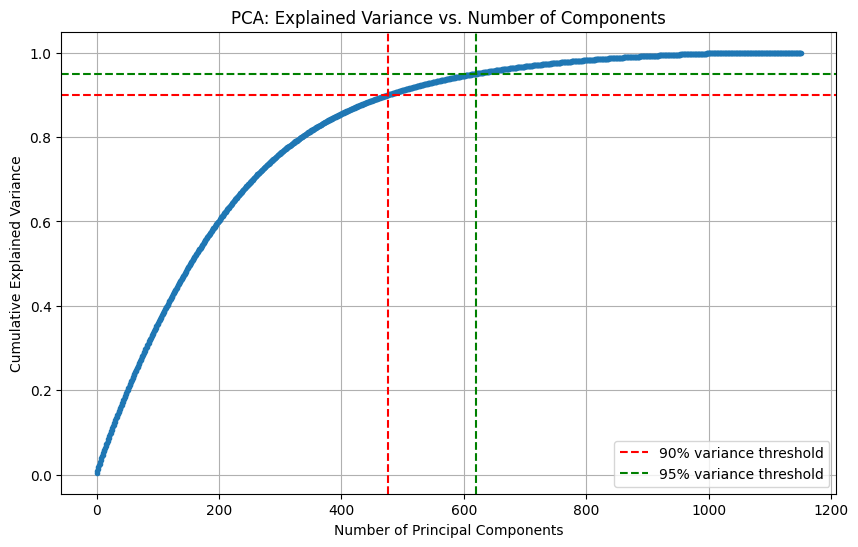

In [5]:
file_str="tadv_5min_wave_group_window_15mins_4"

data=np.load('wave_groups/'+file_str+".npz")
wave_data_train=data["wave_data_train"]
wave_data_test=data["wave_data_test"]
label_train=data["label_train"]
label_test=data["label_test"]

wave_data_train = wave_data_train.reshape(wave_data_train.shape[0], wave_data_train.shape[1])
wave_data_test = wave_data_test.reshape(wave_data_test.shape[0], wave_data_test.shape[1])
num_classes=2

wave_data_train_standardized = (wave_data_train- np.mean(wave_data_train, axis=0)) / np.std(wave_data_train, axis=0)
wave_data_test_standardized = (wave_data_test- np.mean(wave_data_test, axis=0)) / np.std(wave_data_test, axis=0)

pca = PCA()
pca.fit(wave_data_train_standardized)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components needed to explain 90% and 95% of the variance
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(n_components_90)

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance, marker='.')
plt.axhline(y=0.90, color='r', linestyle='--', label='90% variance threshold')
plt.axhline(y=0.95, color='g', linestyle='--', label='95% variance threshold')
plt.axvline(x=n_components_90, color='r', linestyle='--')
plt.axvline(x=n_components_95, color='g', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA: Explained Variance vs. Number of Components')
plt.legend()
plt.grid(True)
plt.savefig("PCA Explained Variance vs. Number of components.jpg", dpi=200)
plt.show()

n_components_req = n_components_90
pca_new = PCA(n_components=n_components_req)
wave_data_train_reconstructed = pca_new.fit_transform(wave_data_train_standardized).reshape(wave_data_train.shape[0], n_components_req, 1)

wave_data_test_reconstructed = pca_new.transform(wave_data_test_standardized).reshape(wave_data_test.shape[0], n_components_req, 1)

#### Use the reconstructed data and prepare the data in the required graph structure

In [6]:
num_nodes = wave_data_train_reconstructed.shape[1]
num_node_features = wave_data_train_reconstructed.shape[2]
num_neighbours = 30  ### Choice for the number of neighbours in the graph structure
batch_size = 32  ### Batch size to be used for creating dataloaders

print("----------------The graph structure will be in the form of multiple graphs------------------".upper())
print("--Each graph will have multiple nodes where each node is an observation of the time series--".upper())
print("----------------------------The feature length of each node is 1----------------------------".upper())
print('\n')
print('-----------------------The graph properties are given below---------------------\n'.upper())
print(f"The number of nodes in each graph is {num_nodes}")
print(f"The number of features for each node is {num_node_features}")
print(f"The number of training set examples is {wave_data_train.shape[0]}")
print(f"The number of test set examples is {wave_data_test.shape[0]}")
print(f"The number of neighbours chosen for each node is {num_neighbours}")

----------------THE GRAPH STRUCTURE WILL BE IN THE FORM OF MULTIPLE GRAPHS------------------
--EACH GRAPH WILL HAVE MULTIPLE NODES WHERE EACH NODE IS AN OBSERVATION OF THE TIME SERIES--
----------------------------THE FEATURE LENGTH OF EACH NODE IS 1----------------------------


-----------------------THE GRAPH PROPERTIES ARE GIVEN BELOW---------------------

The number of nodes in each graph is 477
The number of features for each node is 1
The number of training set examples is 6312
The number of test set examples is 2706
The number of neighbours chosen for each node is 30


#### Create the sparse adjacency matrix and print out the details required for constructing the edge matrix 

In [7]:
def create_adjacency_matrix(num_nodes, directionality=True):
    D_matrix = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(num_nodes):
            D_matrix[i,j] = abs(i-j)

    k = num_neighbours
    A = np.zeros_like(D_matrix)
    for i in range(len(A)):
        neighbours = np.argsort(D_matrix[i])[:k]
        if directionality:
            for n in neighbours:
                if n>i:
                    A[i, n] = 0
                else:
                    A[i, n] = 1 
        else:
            A[i, neighbours] = 1 

    return A

directionality = False
A = create_adjacency_matrix(num_nodes, directionality)
sparse_matrix = sp.coo_matrix(A)
indices = np.column_stack((sparse_matrix.nonzero()))
values = sparse_matrix.data
dense_shape = sparse_matrix.shape
sparse_A = tf.SparseTensor(indices=indices, values=values, dense_shape=dense_shape)

print("---------Details required for constructing the edge matrices-----------\n".upper())
print(f"Are the edges directed? {directionality}")
print(f"The number of edges in each graph is {len(values)}")

---------DETAILS REQUIRED FOR CONSTRUCTING THE EDGE MATRICES-----------

Are the edges directed? False
The number of edges in each graph is 14310


#### Store the edge weights in a file for further use and use if already present

In [8]:
edge_file_path = os.getcwd() + f"\edge_data_15_4_pca_num_neighbors_{num_neighbours}.npz"

if os.path.exists(edge_file_path):
    edge_data=np.load(edge_file_path)
    edge_data_train=edge_data["edge_data_train"]
    edge_data_test=edge_data["edge_data_test"]

else:
    edge_features_train = np.zeros((wave_data_train.shape[0], len(indices)))
    edge_features_test = np.zeros((wave_data_test.shape[0], len(indices)))

    for i in range(edge_features_train.shape[0]):
        for j in range(len(indices)):
            index = indices[j]
            edge_features_train[i,j] = abs(index[1]-index[0])

    for i in range(edge_features_test.shape[0]):
        for j in range(len(indices)):
            index = indices[j]
            edge_features_test[i,j] = abs(index[1]-index[0])

    train_min = np.min(edge_features_train)
    train_max = np.max(edge_features_train)

    test_min = np.min(edge_features_test)
    test_max = np.max(edge_features_test)

    edge_features_train = (edge_features_train - train_min) / (train_max - train_min)
    edge_features_test = (edge_features_test - test_min) / (test_max - test_min)

    np.savez(edge_file_path,edge_data_train=edge_features_train, edge_data_test=edge_features_test)

    edge_data=np.load(edge_file_path)
    edge_data_train=edge_data["edge_data_train"]
    edge_data_test=edge_data["edge_data_test"]

print(f"\nThe shape of the edge weights for training is: {edge_data_train.shape}")
print(f"The shape of the edge weights for testing is: {edge_data_test.shape}")


The shape of the edge weights for training is: (6312, 14310)
The shape of the edge weights for testing is: (2706, 14310)


#### Creating the graphs using the data above, creating the graph dataset and saving it for future use

In [10]:
def create_and_save_graphs(edge_tensor, node_tensor, labels, indices, path):

    graphs = []  
    edge_data = torch.tensor([indices[:,0], indices[:,1]])
        
    num_graphs = len(node_tensor)
    for k in range(num_graphs):
        x = node_tensor[k]
        edge_weights = edge_tensor[k]
        y = labels[k]

        graph = Data(x=x, edge_index=edge_data, edge_weight=edge_weights, y=y)
        graphs.append(graph)

    torch.save(graphs, path)

    return graphs

#### Creating or loading the training, validation and test datasets

In [11]:
### Creating the training, validation and the test datasets
train_val_split = 0.7

### The paths to the saved datasets
train_data_path = 'train_set_pca_graph_classification.pth'
val_data_path = 'val_set_pca_graph_classification.pth'
test_data_path = 'test_set_pca_graph_classification.pth'

if os.path.exists(train_data_path) and os.path.exists(val_data_path) and os.path.exists(test_data_path):
    train_dataset = torch.load(train_data_path)
    val_dataset = torch.load(val_data_path)
    test_dataset = torch.load(test_data_path)

else:
    train_dataset = create_and_save_graphs(edge_data_train[:int(train_val_split * len(edge_data_train)),:], wave_data_train_reconstructed[:int(train_val_split * len(wave_data_train_reconstructed)),:], label_train[:int(train_val_split * len(label_train))], indices, train_data_path)
    val_dataset = create_and_save_graphs(edge_data_train[int(train_val_split * len(edge_data_train)):,:], wave_data_train_reconstructed[int(train_val_split * len(wave_data_train_reconstructed)):,:], label_train[int(train_val_split * len(label_train)):], indices, val_data_path)
    test_dataset = create_and_save_graphs(edge_data_test, wave_data_test_reconstructed, label_test, indices, test_data_path)

C:\Users\samar\AppData\Local\Temp\ipykernel_42540\2466315172.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_dataset = torch.load(train_data_path)
C:\Users\samar\

In [12]:
print("\n ----------------contains the dataset information for the training, validation and test data--------------------\n".upper())
print(f"The training dataset has {len(train_dataset)} graphs".upper())
print(f"The validation dataset has {len(val_dataset)} graphs".upper())
print(f"The testing dataset has {len(test_dataset)} graphs".upper())


 ----------------CONTAINS THE DATASET INFORMATION FOR THE TRAINING, VALIDATION AND TEST DATA--------------------

THE TRAINING DATASET HAS 4418 GRAPHS
THE VALIDATION DATASET HAS 1894 GRAPHS
THE TESTING DATASET HAS 2706 GRAPHS


#### Create the dataloaders for faster data retrieval during model training and adding batch info.

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Printing the info of a batch 
for batch in train_dataloader:
    print("Batch Node Features (x) shape:")
    print(batch.x[0].shape)  # Batched node features
    print("Batch Labels (y) shape:")
    print(batch.y.shape)  # Batched node features
    print("\nBatch Edge Indices (edge_index) shape:")
    print(batch.edge_index.to(torch.int64).dtype)  # Batched edge indices
    print("\nBatch Edge Weights (edge_weight) shape:")
    print(batch.edge_weight[0].shape)  # Batched edge weights
    print("\nBatch Information (batch) shape:")
    print(batch.batch.shape)  # Batch info: indicates graph membership of each node
    print("\nBatch Size:", len(batch.x[0]), "nodes")
    print("Number of Graphs in this Batch:", batch.batch.max().item() + 1)
    # print((torch.tensor(batch.x)).reshape(len(batch.x) * len(batch.x[0]),1).shape)
    # print((torch.tensor(batch.edge_weight)).reshape(len(batch.x) * len(batch.edge_weight[0])).shape)
    break  # Exit after the first batch

Batch Node Features (x) shape:
(477, 1)
Batch Labels (y) shape:
torch.Size([32])

Batch Edge Indices (edge_index) shape:
torch.int64

Batch Edge Weights (edge_weight) shape:
(14310,)

Batch Information (batch) shape:
torch.Size([15264])

Batch Size: 477 nodes
Number of Graphs in this Batch: 32


#### Create the Message Paasing Layer and the Graph Isomorphism Model

In [14]:
class WeightedGINConv(MessagePassing):
    def __init__(self, nn, **kwargs):
        super(WeightedGINConv, self).__init__(aggr='add', **kwargs)  # "Add" aggregation.
        self.nn = nn  # Neural network used in the GIN layer (MLP)

    def forward(self, x, edge_index, edge_weight=None):
        # x: Node features [num_nodes, num_features]
        # edge_index: Edge index tensor [2, num_edges]
        # edge_weight: Edge weight tensor [num_edges]
        
        # Message passing step
        return self.propagate(edge_index, x=x, edge_weight=edge_weight)

    def message(self, x_j, edge_weight):
        # x_j: Represents features of the neighboring nodes
        # edge_weight: We multiply the neighboring features by the edge weight
        if edge_weight is None:
            return x_j
        return edge_weight.view(-1, 1) * x_j

    def update(self, aggr_out):
        # Pass the aggregated messages through the MLP (neural network)
        return self.nn(aggr_out)

- **The graph isomorphism model is composed of three modules.**
- **Initially, the number of features for each node is increased by passing through MLP layers.**
- **The output from the MLP layers is then passed through layers of graph isomorphism layers.**
- **Each graph isomorphism layer contains a sequence of linear layers and batch normlaization to prevent overfitting. Following this, the edge weights are introduced into the model through the Weighted GIN Convolution layers.**
- **The outputs from the graph layers are pooled globally before feeding to a linear layer with sigmoid activation for the final classification.**

In [23]:
class GraphIsomorphismNetwork(torch.nn.Module):
    """
    Creates a gnn model based on global pooling of embeddings - for graph level classifications
    """
    def __init__(self, dim_pre_MLP, dim_post_MLP, dim_graphLin, num_pre_layers, num_post_layers, dropout_prob, num_graph_layers, training=True):
        
        self.dim_pre_MLP = dim_pre_MLP
        self.dim_post_MLP = dim_post_MLP
        self.dim_graphLin = dim_graphLin
        self.num_pre_layers = num_pre_layers
        self.num_post_layers = num_post_layers
        self.num_graph_layers = num_graph_layers
        self.dropout_prob = dropout_prob
        self.training = training

        super(GraphIsomorphismNetwork, self).__init__()

        self.sigmoid = Sigmoid()

        ### Each MLP module has two linear layers, each followed by activation functions of ReLU
        self.MLP = nn.ModuleList()
        for i in range(self.num_pre_layers):
            if i==0:
                mlp_layer = Sequential(Linear(num_node_features, self.dim_pre_MLP), ReLU()) 
                self.MLP.append(mlp_layer)
            else:
                mlp_layer = Sequential(Linear(self.dim_pre_MLP , self.dim_pre_MLP), ReLU()) 
                self.MLP.append(mlp_layer)
                    
        ### The MLP layers is followed by graph convolutional layers
        self.graphLayers = nn.ModuleList()
        for i in range(self.num_graph_layers):
            if i==0:
                if self.training:
                    mlp_layer = Sequential(Linear(self.dim_pre_MLP, self.dim_graphLin), BatchNorm1d(self.dim_graphLin), Dropout(self.dropout_prob), ReLU(), 
                                         Linear(self.dim_graphLin, self.dim_graphLin), BatchNorm1d(self.dim_graphLin), Dropout(self.dropout_prob), ReLU())
                    # gconv_layer = GINConv(mlp_layer)
                    gconv_layer = WeightedGINConv(mlp_layer)
                else:
                    mlp_layer = Sequential(Linear(self.dim_pre_MLP, self.dim_graphLin), BatchNorm1d(self.dim_graphLin), ReLU(), 
                                         Linear(self.dim_graphLin, self.dim_graphLin), BatchNorm1d(self.dim_graphLin), ReLU())
                    # gconv_layer = GINConv(mlp_layer)
                    gconv_layer = WeightedGINConv(mlp_layer)
                
                self.graphLayers.append(gconv_layer)
            else:
                if self.training:
                    mlp_layer = Sequential(Linear(self.dim_graphLin, self.dim_graphLin), BatchNorm1d(self.dim_graphLin), Dropout(self.dropout_prob), ReLU(), 
                                         Linear(self.dim_graphLin, self.dim_graphLin), BatchNorm1d(self.dim_graphLin), Dropout(self.dropout_prob), ReLU())
                    # gconv_layer = GINConv(mlp_layer)
                    gconv_layer = WeightedGINConv(mlp_layer)
                else:
                    mlp_layer = Sequential(Linear(self.dim_graphLin, self.dim_graphLin), BatchNorm1d(self.dim_graphLin), ReLU(), 
                                         Linear(self.dim_graphLin, self.dim_graphLin), BatchNorm1d(self.dim_graphLin), ReLU())
                    # gconv_layer = GINConv(mlp_layer)
                    gconv_layer = WeightedGINConv(mlp_layer)
           
                self.graphLayers.append(gconv_layer)
        
        
        ### The graph convolutional layers are followed by post processing layers
        ### Each MLP module has two linear layers, each followed by activation functions of ReLU
        self.postGCLayers = nn.ModuleList()
        for i in range(self.num_post_layers):
            if i==0 and i!=self.num_post_layers-1:
                if self.training:
                    mlp_layer = Sequential(Linear(self.num_graph_layers*self.dim_graphLin, self.dim_post_MLP), Dropout(self.dropout_prob), ReLU())
                else:
                    mlp_layer = Sequential(Linear(self.num_graph_layers*self.dim_graphLin, self.dim_post_MLP), ReLU())
                self.postGCLayers.append(mlp_layer)

            elif i==0 and i==self.num_post_layers-1:
                mlp_layer = Linear(self.num_graph_layers*self.dim_graphLin, 1)
                self.postGCLayers.append(mlp_layer)

            elif i>0 and i<self.num_post_layers-1:
                if self.training:
                    mlp_layer = Sequential(Linear(self.dim_post_MLP, self.dim_post_MLP), Dropout(self.dropout_prob), ReLU())
                else:
                    mlp_layer = Sequential(Linear(self.dim_post_MLP, self.dim_post_MLP), ReLU())
                self.postGCLayers.append(mlp_layer)
                
            else:
                mlp_layer = Linear(self.dim_post_MLP, 1)
                self.postGCLayers.append(mlp_layer)

    def forward(self, x, edge_indices, edge_weights, batch):
        ## Pre-processing layers (MLP modules)
        # print(batch)
        # print(f"The number of unique batches in the batch tensor is {len(torch.unique(batch))}")
        for i in range(self.num_pre_layers):
            x = self.MLP[i](x)

        # print(f"The shape of the input at the end of the pre-processing MLP layers is {x.shape}")
        # print(f"The shape of the the weights fed to the model is {edge_weights.shape}")
        ## Node embeddings
        h = []
        for k in range(self.num_graph_layers):
            x = self.graphLayers[k](x, edge_indices, edge_weights)
            # print(f"The shape of the embedding at the end of the graph layer {k} is {x.shape}")
            h.append(x)

        ## Graph-level pooling
        for k in range(self.num_graph_layers):
            h[k] = global_mean_pool(h[k], batch)
            # print(f"The shape of the embedding after graph level global pooling is {h[0].shape}")

        ## concatenate graph embeddings
        h_concat = torch.cat(h, dim=1)
        # print(f"The shape of the input after concatenating the graph embeddings is {h_concat.shape}")

        ### Post-processing and classification
        if self.num_post_layers == 1:
            h_concat = self.sigmoid(self.postGCLayers[i](h_concat))
        else:
            for i in range(self.num_post_layers):
                if i < self.num_pre_layers-1:
                    h_concat = self.postGCLayers[i](h_concat)
                else:
                    h_concat = self.sigmoid(self.postGCLayers[i](h_concat)) 
                    
            # print(f"The shape of the input at the end of the post-processing MLP layer {i} is {h_concat.shape}")

        # print(f"The shape of the input at the end of the post-processing MLP layers is {h_concat.shape}")
        # print(f"The output is:{h_concat}")

        return h_concat

In [24]:
class GraphIsomorphismNetworkWithSkipConnections(torch.nn.Module):
    """
    Creates a gnn model based on global pooling of embeddings - for graph level classifications
    """
    def __init__(self, dim_pre_MLP, dim_post_MLP, dim_graphLin, num_pre_layers, num_post_layers, dropout_prob, num_graph_layers, training=True):
        
        self.dim_pre_MLP = dim_pre_MLP
        self.dim_post_MLP = dim_post_MLP
        self.dim_graphLin = dim_graphLin 
        self.num_pre_layers = num_pre_layers  ## Now, it gives the number of dense layers
        self.num_post_layers = num_post_layers  ## Now, it gives the number of dense layers
        self.num_graph_layers = num_graph_layers
        self.dropout_prob = dropout_prob
        self.training = training

        super(GraphIsomorphismNetworkWithSkipConnections, self).__init__()
        self.MLP = nn.ModuleList()
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        for i in range(self.num_pre_layers):
            if i==0:
                linear_layer = Linear(num_node_features, self.dim_pre_MLP)
                self.MLP.append(linear_layer)
            else:
                linear_layer = Linear(self.dim_pre_MLP + num_node_features, self.dim_pre_MLP)
                self.MLP.append(linear_layer)
                    
        ### The MLP layers is followed by graph convolutional layers
        self.graphLayers = nn.ModuleList()
        for i in range(self.num_graph_layers):
            if i==0:
                if self.training:
                    mlp_layer = Sequential(Linear(self.dim_pre_MLP, self.dim_graphLin), BatchNorm1d(self.dim_graphLin), Dropout(self.dropout_prob), ReLU(), 
                                         Linear(self.dim_graphLin, self.dim_graphLin), BatchNorm1d(self.dim_graphLin), Dropout(self.dropout_prob), ReLU())
                    # gconv_layer = GINConv(mlp_layer)
                    gconv_layer = WeightedGINConv(mlp_layer)
                else:
                    mlp_layer = Sequential(Linear(self.dim_pre_MLP, self.dim_graphLin), BatchNorm1d(self.dim_graphLin), ReLU(), 
                                         Linear(self.dim_graphLin, self.dim_graphLin), BatchNorm1d(self.dim_graphLin), ReLU())
                    # gconv_layer = GINConv(mlp_layer)
                    gconv_layer = WeightedGINConv(mlp_layer)
                
                self.graphLayers.append(gconv_layer)
            else:
                if self.training:
                    mlp_layer = Sequential(Linear(self.dim_graphLin, self.dim_graphLin), BatchNorm1d(self.dim_graphLin), Dropout(self.dropout_prob), ReLU(), 
                                         Linear(self.dim_graphLin, self.dim_graphLin), BatchNorm1d(self.dim_graphLin), Dropout(self.dropout_prob), ReLU())
                    # gconv_layer = GINConv(mlp_layer)
                    gconv_layer = WeightedGINConv(mlp_layer)
                else:
                    mlp_layer = Sequential(Linear(self.dim_graphLin, self.dim_graphLin), BatchNorm1d(self.dim_graphLin), ReLU(), 
                                         Linear(self.dim_graphLin, self.dim_graphLin), BatchNorm1d(self.dim_graphLin), ReLU())
                    # gconv_layer = GINConv(mlp_layer)
                    gconv_layer = WeightedGINConv(mlp_layer)
           
                self.graphLayers.append(gconv_layer)
        
        
        ### The graph convolutional layers are followed by post processing layers
        ### Each MLP module has two linear layers, each followed by activation functions of ReLU
        self.postGCLayers = nn.ModuleList()
        self.dropout_layers = nn.ModuleList()
        for i in range(self.num_post_layers):
            if i==0 and i!=self.num_post_layers-1:
                linear_layer = Linear(self.num_graph_layers*self.dim_graphLin, self.dim_post_MLP)
                self.postGCLayers.append(linear_layer)
                if self.training:
                    self.dropout_layers.append(Dropout(self.dropout_prob))
            
            elif i==0 and i==self.num_post_layers-1:
                linear_layer = Linear(self.num_graph_layers*self.dim_graphLin, 1)
                self.postGCLayers.append(linear_layer)

            elif i>0 and i<self.num_post_layers-1:
                linear_layer = Linear(self.dim_post_MLP + self.dim_post_MLP, self.dim_post_MLP)
                self.postGCLayers.append(linear_layer)
                if self.training:
                    self.dropout_layers.append(Dropout(self.dropout_prob))
                
            else:
                linear_layer = Linear(self.dim_post_MLP + self.dim_post_MLP, 1)
                self.postGCLayers.append(linear_layer)

    def forward(self, x, edge_indices, edge_weights, batch):
        ## Pre-processing layers (MLP modules)
        # print(batch)
        # print(f"The number of unique batches in the batch tensor is {len(torch.unique(batch))}")
        if self.num_pre_layers == 1:
            x = self.relu(self.MLP[i](x))
        else:
            for i in range(self.num_pre_layers):
                if i < self.num_pre_layers-1:
                    # print(f"The shape of the input at the start of the pre-processing layer{i} is {x.shape}")
                    x_out = self.relu(self.MLP[i](x))
                    # print(f"The shape of the input at the end of the pre-processing layer{i} is {x_out.shape}")
                    x = torch.cat([x_out,x], dim=-1)
                    # print(f"The shape of the input after concatenation at the end of the pre-processing layer{i} is {x.shape}")
                else:
                    x = self.relu(self.MLP[i](x))
                    # print(f"The shape of the input at the end of the pre-processing layer{i} is {x.shape}")

        # print(f"The shape of the input at the end of the pre-processing MLP layers is {x.shape}")
        # print(f"The shape of the the weights fed to the model is {edge_weights.shape}")
        ## Node embeddings
        h = []
        for k in range(self.num_graph_layers):
            x = self.graphLayers[k](x, edge_indices, edge_weights)
            # print(f"The shape of the embedding at the end of the graph layer {k} is {x.shape}")
            h.append(x)

        ## Graph-level pooling
        for k in range(self.num_graph_layers):
            h[k] = global_mean_pool(h[k], batch)
            # print(f"The shape of the embedding after graph level global pooling is {h[0].shape}")

        ## concatenate graph embeddings
        h_concat = torch.cat(h, dim=1)
        # print(f"The shape of the input after concatenating the graph embeddings is {h_concat.shape}")

        ### Post-processing and classification
        if self.num_post_layers == 1:
            h_concat = self.sigmoid(self.postGCLayers[i](h_concat))
        else:
            for i in range(self.num_post_layers):
                if i < self.num_pre_layers-1:
                    h_concat = self.postGCLayers[i](h_concat)
                    if self.training:
                        h_concat = self.dropout_layers[i](h_concat)
                    h_concat_out = self.relu(h_concat)
                    h_concat = torch.cat([h_concat_out,h_concat], dim=-1)

                else:
                    h_concat = self.sigmoid(self.postGCLayers[i](h_concat))
            # print(f"The shape of the input at the end of the post-processing MLP layer {i} is {h_concat.shape}")

        # print(f"The shape of the input at the end of the post-processing MLP layers is {h_concat.shape}")
        # print(f"The output is:{h_concat}")

        return h_concat

#### Hyperparameters to be tested

In [25]:
### Hyperparameters to be tested
training = True
dim_pre_MLP = 32
dim_post_MLP = 32
dim_graphLin = 32
num_pre_layers = 2
num_post_layers = 2
dropout_prob = 0.1
num_graph_layers = 3
patience_new = 15

In [ ]:
dict = {"dim_pre_MLP": dim_pre_MLP,
        "dim_post_MLP": dim_post_MLP,
        "dim_graphLin": dim_graphLin,
        "num_pre_layers": num_pre_layers,
        "num_post_layers": num_post_layers,
        "dropout_prob": dropout_prob,
        "num_graph_layers": num_graph_layers,
        "patience": patience_new,
        "batch size": batch_size,
        "num neighbours": num_neighbours}

for key, val in dict.items():
    print(f"{key} : {val}")

#### File save names to be used for the saving of metrics and model

In [26]:
file_str = f"GraphClassification_PCA_GIN_pre_MLP_dim_{dim_pre_MLP}"
curves_filename = os.getcwd()+'/training_history_'+'/'+ file_str +'.jpg'
model_filename = os.getcwd()+'/model_saves_'+'/'+ file_str +'.pt'
accuracy_filename = os.getcwd()+'/accuracy_saves_'+'/'+ file_str+'.txt'
time_filename = os.getcwd()+'/time_saves_'+'/'+ file_str+'.txt'

#### Accuracy computation

In [27]:
def compute_accuracy(preds, labels):
    # print(f"Output:{preds}")
    # print(f"Labels:{labels}")
    predicted_classes = (preds > 0.5).float()
    # print(f"Predicted classes:{predicted_classes}")
    num_correct = (predicted_classes == labels).float().sum()
    # print(f"Number of correctly predicted results: {num_correct}")
    # print(f"Total number of items: {labels.shape[0]}")
    accuracy = num_correct / labels.shape[0]
    return accuracy.item()

### Training and validation loops

In [37]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

def trainVal(model, dataloader):
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay= 0.01)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=5)

    num_epochs = 2

    ##Early stopping parameters
    best_val_loss = float('inf')
    patience = patience_new
    counter = 0
    best_model_path = model_filename

    ## Keep track of the losses and accuracies over epochs
    training_losses = []
    training_accuracies = []
    validation_losses = []
    validation_accuracies = []
    
    for epoch in range(num_epochs+1):
        
        model.train() ## Training mode
        
        train_acc = 0
        train_loss = 0

        for batch in dataloader:
            edge_indices = batch.edge_index.to(torch.int64)
            node_features = (torch.tensor(batch.x)).reshape(len(batch.x) * len(batch.x[0]),1).float() 
            edge_weights = (torch.tensor(batch.edge_weight)).reshape(len(batch.x) * len(batch.edge_weight[0])).float()
            labels = batch.y.reshape(len(batch.x) ,1).float()
            batches = batch.batch
            num_unique_batches = len(torch.unique(batches))
            batches %= num_unique_batches

            ## Forward pass
            optimizer.zero_grad()
            output = model(node_features, edge_indices, edge_weights, batches)
            # print(f"Output shape is:{output.shape}")
            loss = criterion(output, labels)

            ## Backward propagation and optimization 
            loss.backward()
            torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=0.5)
            optimizer.step()

            ## Keep track of the losses and accuracies
            train_loss += loss.item()
            train_acc += compute_accuracy(output, labels)

        # print(f"Dataloader length:{len(dataloader)}")
        # print(f"Train loss: {train_loss}")
        # print(f"Train accuracy: {train_acc}")
        
        epoch_loss = train_loss / len(dataloader)
        epoch_accuracy = train_acc / len(dataloader)

        training_losses.append(epoch_loss)
        training_accuracies.append(epoch_accuracy)

        ## validation
        val_loss = 0.0
        val_acc = 0.0
        
        model.eval()  ## evaluation state
        with torch.no_grad():
            for batch in val_dataloader:
                edge_indices = batch.edge_index.to(torch.int64)
                node_features = (torch.tensor(batch.x)).reshape(len(batch.x) * len(batch.x[0]),1).float() 
                edge_weights = (torch.tensor(batch.edge_weight)).reshape(len(batch.x) * len(batch.edge_weight[0])).float()
                labels = batch.y.reshape(len(batch.x) ,1).float()
                batches = batch.batch
                num_unique_batches = len(torch.unique(batches))
                batches %= num_unique_batches

                # edge_indices = data[0]
                # node_features = data[1]
                # edge_weights = data[2]
                # labels = data[3]
                # batches = data[4]
        
                output = model(node_features, edge_indices, edge_weights, batches)
                val_loss += criterion(output, labels).item()
                val_acc += compute_accuracy(output, labels)

        validation_loss = val_loss/len(val_dataloader)
        validation_acc = val_acc/len(val_dataloader)

        scheduler.step(val_loss)

        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_acc)

        ## print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {epoch_loss:.2f}'
              f'| Train Acc: {epoch_accuracy*100:4.3f}% '
              f'| Val Loss: {validation_loss:.2f} '
              f'| Val Acc: {validation_acc*100: 4.3f}%')

        ### Check for the validation loss improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), best_model_path)
            # print(f'Saving the model with val loss: {val_loss:.4f}')
        else:
            counter +=1

        ### Early stopping condition
        if counter >= patience:
            print("Early stopping triggered.")
            break

    ## Put the losses and accuracies in a dictionary which can be returned
    losses = {"Train loss": training_losses,
              "Train accuracy": training_accuracies,
              "Validation loss": validation_losses,
              "Validation accuracy": validation_accuracies}

    return losses

### Prediction loop

In [38]:
@torch.no_grad()
def test(model):
    criterion = torch.nn.BCELoss()
    model.eval()
    test_loss = 0
    test_acc = 0

    for batch in test_dataloader:
        edge_indices = batch.edge_index.to(torch.int64)
        node_features = (torch.tensor(batch.x)).reshape(len(batch.x) * len(batch.x[0]),1).float() 
        edge_weights = (torch.tensor(batch.edge_weight)).reshape(len(batch.x) * len(batch.edge_weight[0])).float()
        labels = batch.y.reshape(len(batch.x) ,1).float()
        batches = batch.batch
        num_unique_batches = len(torch.unique(batches))
        batches %= num_unique_batches
        
        output = model(node_features, edge_indices, edge_weights, batches)
        test_loss += criterion(output, labels).item()
        test_acc += compute_accuracy(output, labels)

    testing_loss = test_loss / len(test_dataloader)
    testing_acc = test_acc / len(test_dataloader)

    return testing_loss, testing_acc


#### Training the model using GIN

In [1]:
# start_time = time.time()

# ### Training and evaluation of the model
# model = GraphIsomorphismNetwork(dim_pre_MLP, dim_post_MLP, dim_graphLin, num_pre_layers, num_post_layers, dropout_prob, num_graph_layers, training)
# train_val_metrics = trainVal(model, train_dataloader)

# end_time = time.time()
# elapsed_time = end_time - start_time
# print(f"Elapsed time is {elapsed_time / 60:3.2f} minutes.") 

#### Training the model using GIN with skip connections

In [40]:
start_time = time.time()

### Training and evaluation of the model
model = GraphIsomorphismNetworkWithSkipConnections(dim_pre_MLP, dim_post_MLP, dim_graphLin, 
                                                   num_pre_layers, num_post_layers, dropout_prob, num_graph_layers, training)
train_val_metrics = trainVal(model, train_dataloader)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time is {elapsed_time / 60:3.2f} minutes.") 

Epoch   0 | Train Loss: 0.66| Train Acc: 62.118% | Val Loss: 0.63 | Val Acc:  64.219%
Elapsed time is 1.95 minutes.


In [41]:
elapsed_time = np.array([round(elapsed_time, 4)])
np.savetxt(time_filename, elapsed_time, fmt='%.4f')

#### Plotting the model training metrics

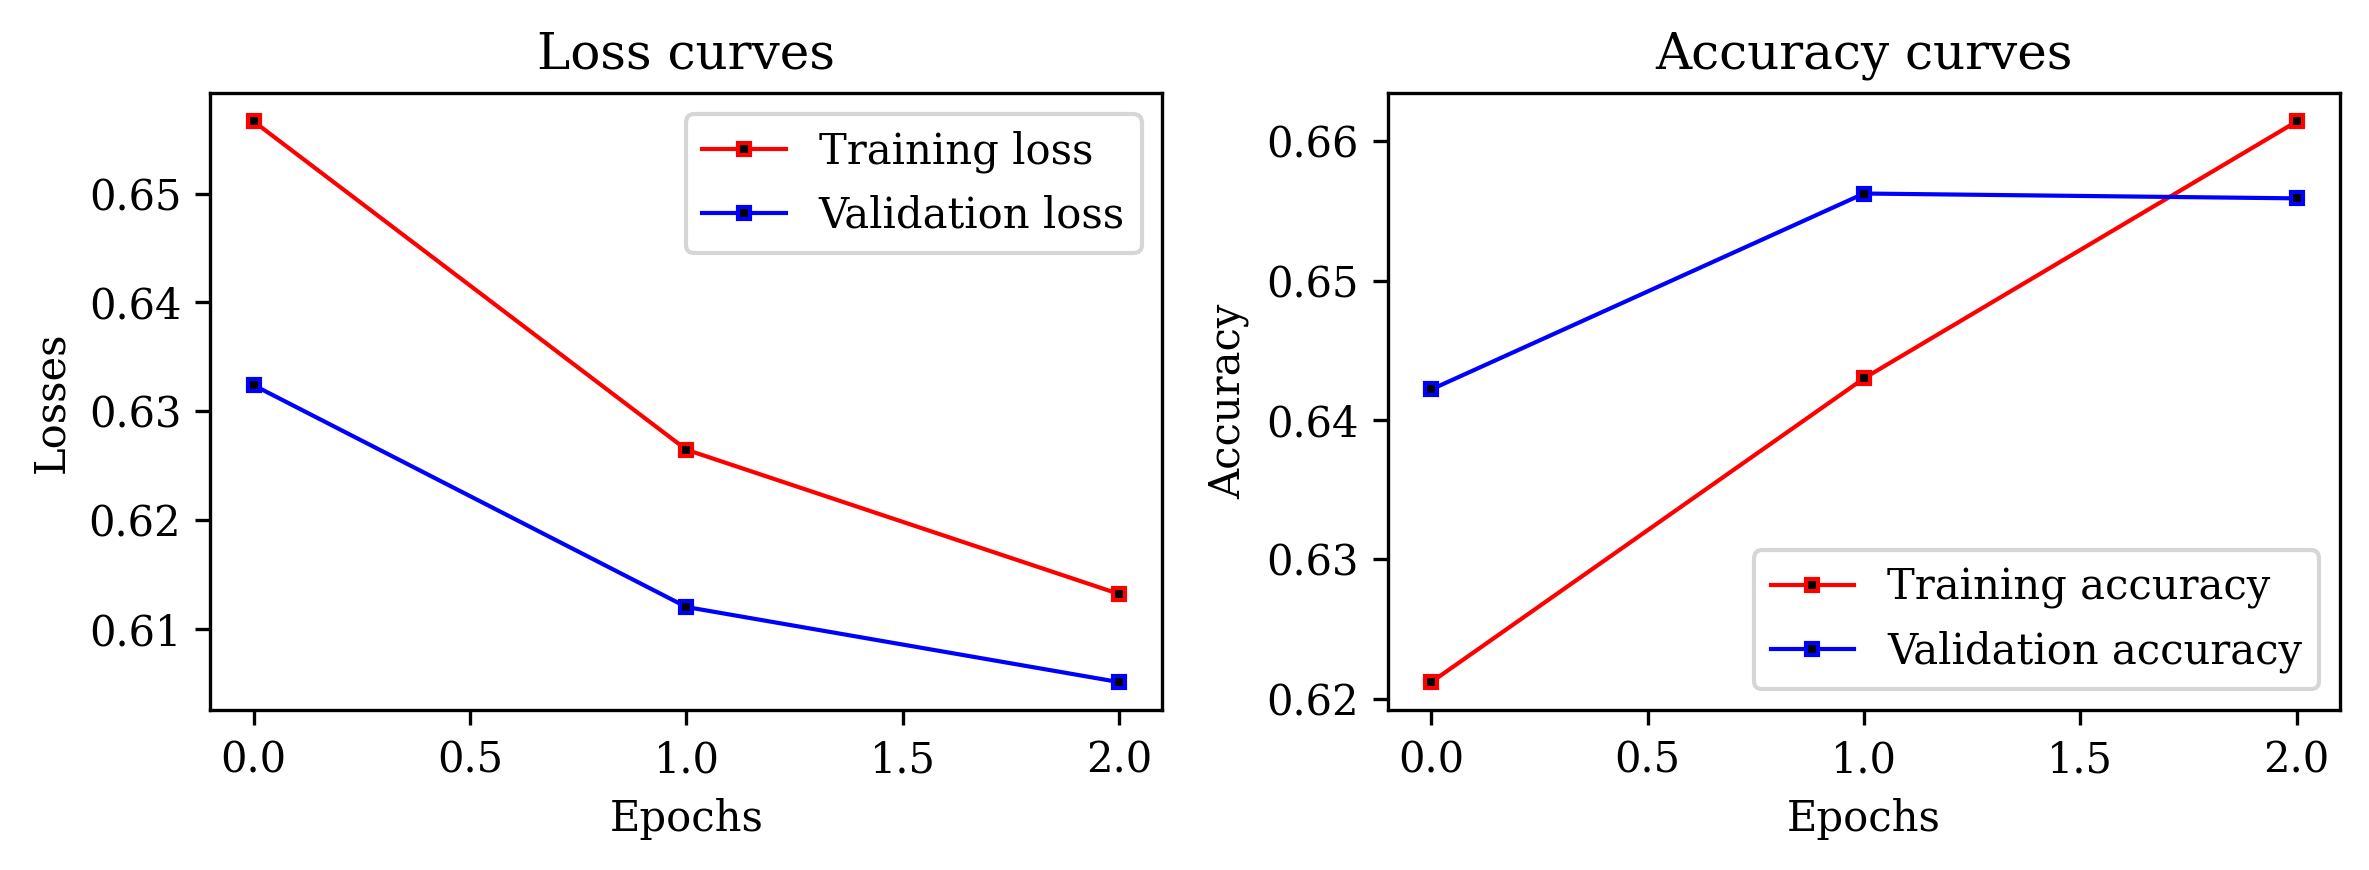

In [42]:
plt.rcParams["font.family"]="serif"
epochs = np.arange(0, len(train_val_metrics["Train loss"]))

fig,ax = plt.subplots(1,2, figsize=[8,3], dpi=300)
ax[0].plot(epochs, train_val_metrics["Train loss"], 'red', linestyle = '-', linewidth=1.0, marker = 's', mfc = 'k', markersize = 3, label = 'Training loss')
ax[0].plot(epochs, train_val_metrics["Validation loss"], 'blue', linestyle = '-', linewidth=1.0, marker = 's', mfc = 'k', markersize = 3, label = 'Validation loss')
ax[0].set_title('Loss curves')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Losses")
ax[0].legend()

ax[1].plot(epochs, train_val_metrics["Train accuracy"], 'red', linestyle = '-', linewidth=1.0, marker = 's', mfc = 'k', markersize = 3, label = 'Training accuracy')
ax[1].plot(epochs, train_val_metrics["Validation accuracy"], 'blue', linestyle = '-', linewidth=1.0, marker = 's', mfc = 'k', markersize = 3, label = 'Validation accuracy')
ax[1].set_title('Accuracy curves')
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

plt.tight_layout()
plt.savefig(curves_filename,dpi=199)
# plt.show()

#### Evaluating the model on the test data and calculating the metrics

In [43]:
model = GraphIsomorphismNetworkWithSkipConnections(dim_pre_MLP, dim_post_MLP, dim_graphLin, num_pre_layers, num_post_layers, dropout_prob, num_graph_layers, training=False)
model.load_state_dict(torch.load(model_filename))
model.eval()

test_metrics = test(model)
formatted_accuracy = "{:.4f}".format(test_metrics[1])
formatted_loss = "{:.4f}".format(test_metrics[0])

print(f"Test loss: {formatted_loss}")
print(f"Test accuracy: {formatted_accuracy}")

test_loss = test_metrics[0]
test_accuracy = np.array([round(test_metrics[1], 4)])

np.savetxt(accuracy_filename, test_accuracy, fmt='%.4f')

C:\Users\samar\AppData\Local\Temp\ipykernel_42540\116350147.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_filename))


Test loss: 0.6922
Test accuracy: 0.6454
